# 06 Nanocrystal segmentation in scanning precession electron diffraction data - Full demonstration on partly overlapping MgO cubes

This notebook demonstrates two approaches to nanocrystal segmentation:
1. Virtual dark-field (VDF) imaging-based segmentation
2. Non-negative matrix factorisation (NMF)-based segmentation

The segmentation is demonstrated on a SPED dataset of partly overlapping MgO nanoparticles, where some of the particles share the same orientation. The SPED data can be found in [1]. An article including explanation of the methods and discussions of the results is under review. 

[1] T Bergh. (2019) *Scanning precession electron diffraction data of partly overlapping magnesium oxide nanoparticles.* doi: 10.5281/zenodo.3382874.

In [1]:
%matplotlib qt

In [2]:
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt
import pyxem as pxm

# Load and pre-process data

## Load and bin data

Load the binned data, or alternatively load the full data and bin it in navigation space:

`s = hs.load('SPED_data_of_MgO_nanoparticles.hdf5')
s = s.rebin(scale=(2,2,1,1))
s = pxm.ElectronDiffraction2D(s)`

In [3]:
s = pxm.load_hspy('MgO2_16_TX5_c_bin2,2.hdf5',
                  lazy=False, 
                  assign_to='electron_diffraction2d')

Inspect the dataset

In [4]:
s.plot(cmap='magma_r')

### Align the direct beam

TODO : Add option for square_width in the get_direct_beam_position function

In [5]:
def get_center_beam_position(self, radius_start, radius_finish,
                             square_width=None, *args, **kwargs):
    """Estimate the direct beam position in each experimentally acquired
    electron diffraction pattern.

    Parameters
    ----------
    radius_start : int
        The lower bound for the radius of the central disc to be used in the
        alignment.
    radius_finish : int
        The upper bounds for the radius of the central disc to be used in
        the alignment.
    square_width  : int
        Half the side length of square that captures the direct beam in all
        scans. Means that the centering algorithm is stable against
        diffracted spots brighter than the direct beam.
    *args:
        Arguments to be passed to align2D().
    **kwargs:
        Keyword arguments to be passed to align2D().

    Returns
    -------
    shifts : np.ndarray
        The positions of the centre of the direct beam.

    """
    nav_shape_x = self.data.shape[0]
    nav_shape_y = self.data.shape[1]
    origin_coordinates = np.array((self.data.shape[2] / 2 - 0.5,
                                   self.data.shape[3] / 2 - 0.5))

    if square_width is not None:
        min_index = np.int(origin_coordinates[0] - (0.5 + square_width))
        # fails if non-square dp
        max_index = np.int(origin_coordinates[0] + (1.5 + square_width))
        shifts = self.isig[min_index:max_index, min_index:max_index].get_direct_beam_position(
            radius_start=radius_start, radius_finish=radius_finish, *args, **kwargs)
    else:
        shifts = self.get_direct_beam_position(
            radius_start=radius_start, radius_finish=radius_finish, *args, **kwargs)

    shifts = -1 * shifts.data
    shifts = shifts.reshape(nav_shape_x * nav_shape_y, 2)

    return shifts

Find the direct beam positions. 

It is easier to find the centre positions on a dataset where the background is removed, so we do that, and then apply the found shifts to the unprocessed dataset. 

In [6]:
sigma_min = 1.7
sigma_max = 13.2

shifts = get_center_beam_position(
    s.remove_background('gaussian_difference', 
                        sigma_min=sigma_min, 
                        sigma_max=sigma_max),
    radius_start=2, radius_finish=6, square_width=15)

Visualise the direct beam positions

In [7]:
plt.figure()
plt.imshow(shifts.reshape(s.data.shape[0],s.data.shape[1],2)[..., 0])
plt.figure()
plt.imshow(shifts.reshape(s.data.shape[0],s.data.shape[1],2)[..., 1])

Align the centre of the direct beam so that it is found at the same positional coordinate in all PED patterns

In [8]:
s.align2D(shifts=shifts, fill_value=0, crop=True)

## Set calibrations

In [9]:
scale = 0.03246
scale_real = 2.56
s.set_diffraction_calibration(scale)
s.set_scan_calibration(scale_real)

# 1 Virtual dark field imaging-based segmentation

## 1(a) Pre-processing for VDF imaging-based segmentation
Continue with pre-processing that is only needed for the VDF imaging-based segmentation approach.

### Remove the background

In [10]:
sigma_min = 1.7
sigma_max = 13.2

s_rb = s.remove_background('gaussian_difference',
                           sigma_min=sigma_min,
                           sigma_max=sigma_max)

In [11]:
s_rb.set_diffraction_calibration(scale)
s_rb.set_scan_calibration(scale_real)

### Peak finding
Find all diffraction peaks for all PED patterns. 
The used parameters were found by interactive peak finding:

`peaks = s_rb.find_peaks_interactive(imshow_kwargs={'cmap': 'magma_r'})`

In [12]:
peaks = s_rb.find_peaks(method='laplacian_of_gaussians', 
                        min_sigma=0.7,
                        max_sigma=10,
                        num_sigma=30, 
                        threshold=0.046, 
                        overlap=0.5, 
                        log_scale=False,
                        exclude_border=True)

Visualise the number of diffraction peaks found pr. probe position

In [13]:
diff_map = peaks.get_diffracting_pixels_map()
diff_map.plot()

#### Refine the peak positions

In [14]:
from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from pyxem.signals.diffraction_vectors import DiffractionVectors

Since we have peaks at the edges of the patterns, we zero-pad the signal, to avoid errors during the refinement.

In [15]:
s_padded = np.zeros((s.data.shape[0],s.data.shape[1],
                     s.data.shape[2]+12,s.data.shape[2]+12))
s_padded[:,:,6:s.data.shape[2]+6,6:s.data.shape[2]+6] = s_rb.data
s_padded = pxm.ElectronDiffraction2D(s_padded)
s_padded.set_diffraction_calibration(scale)
s_padded.set_scan_calibration(scale_real)

TODO : Integrate a solution to this in pyxem?

In [16]:
refine_gen = SubpixelrefinementGenerator(s_padded, peaks)
peaks_refined = DiffractionVectors(
    refine_gen.center_of_mass_method(square_size=4))
peaks_refined.axes_manager.set_signal_dimension(0)

In [17]:
s_padded = None

### Find the unique diffraction peaks by clustering

In [18]:
distance_threshold = scale*0.89
min_samples = 10

unique_peaks = peaks_refined.get_unique_vectors(method='DBSCAN',
    distance_threshold=distance_threshold, min_samples=min_samples)
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

57  unique vectors were found.


Visualise the detected unique peaks by plotting them on the maximum of the signal. 

In [19]:
radius_px = s_rb.axes_manager.signal_shape[0]/2
reciprocal_radius = radius_px * scale

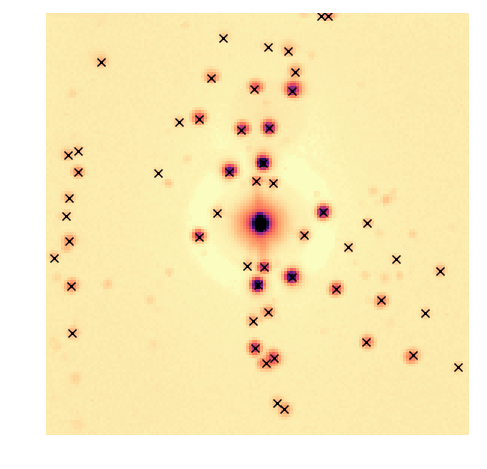

In [20]:
unique_peaks.plot_diffraction_vectors(
    method='DBSCAN',
    unique_vectors=unique_peaks,
    distance_threshold=distance_threshold,
    xlim=reciprocal_radius,
    ylim=reciprocal_radius,
    min_samples=min_samples,
    image_to_plot_on=s_rb.max(),
    image_cmap='magma_r',
    plot_label_colors=False)

Visualise both the clusters and the unique peaks obtained after DBSCAN clustering. 

*NB The cluster colors are randomly generated, so run it again if it is hard to discern two close clusters.*

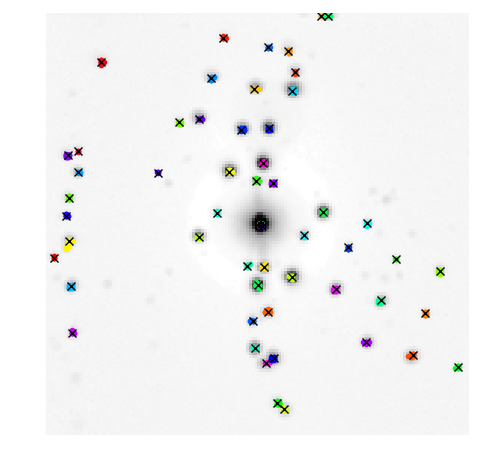

In [21]:
peaks_refined.plot_diffraction_vectors(
    method='DBSCAN',
    xlim=reciprocal_radius, 
    ylim=reciprocal_radius,
    unique_vectors=unique_peaks, 
    distance_threshold=distance_threshold,
    min_samples=min_samples, 
    image_to_plot_on=s_rb.max(), 
    image_cmap='gray_r',
    plot_label_colors=True, 
    distance_threshold_all=scale*0.1)

Filter the unique vectors by magnitude in order to exclude the direct beam from the following analysis

In [22]:
gmags = unique_peaks.get_magnitudes()
gmags.data[gmags.data<10*scale] = 0
Gs = unique_peaks.data[np.where(gmags)]
Gs = pxm.DiffractionVectors(Gs)
print(np.shape(Gs)[0], ' unique vectors.')
Gs.axes_manager.set_signal_dimension(0)

53  unique vectors.


Plot the unique vectors

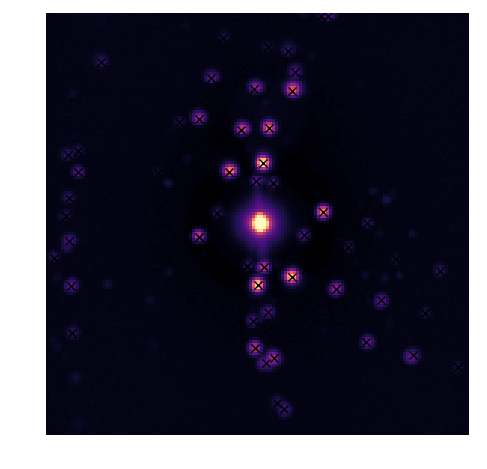

In [23]:
Gs.plot_diffraction_vectors(unique_vectors=Gs,
                            distance_threshold=distance_threshold,
                            xlim=reciprocal_radius,
                            ylim=reciprocal_radius,
                            min_samples=min_samples,
                            image_to_plot_on=s_rb.max(),
                            image_cmap='magma',
                            plot_label_colors=False)

Optionally save and load the unique peaks

`np.save('peaks.npy', Gs.data)
Gs = np.load('peaks.npy', allow_pickle=True)
Gs = pxm.DiffractionVectors(Gs)
Gs.axes_manager.set_signal_dimension(0)`

### Calculate VDF images for all unique peaks

In [24]:
from pyxem.generators.vdf_generator import VDFGenerator

In [25]:
radius=scale*2

vdfgen = VDFGenerator(s_rb, Gs)
VDFs = vdfgen.get_vector_vdf_images(radius=radius)

In [26]:
VDFs.plot(cmap='magma', scalebar=False)

## 1(b) Watershed segmentation

First find adequate parameters by looking at watershed segmentation of a single VDF image.

In [27]:
from pyxem.utils.segment_utils import separate_watershed

In [28]:
min_distance = 5.5
min_size = 10
max_size = None
max_number_of_grains = np.inf
marker_radius = 2
exclude_border = 2

In [29]:
i = 27
sep_i = separate_watershed(
    VDFs.inav[i].data, min_distance=min_distance, min_size=min_size,
    max_size=max_size, max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, marker_radius=marker_radius,
    threshold=True, plot_on=True)

Perform segmentation on all the VDF images

In [30]:
segs = VDFs.get_vdf_segments(min_distance=min_distance,
                                  min_size=min_size,
                                  max_size = max_size,
                                  max_number_of_grains = max_number_of_grains,
                                  exclude_border=exclude_border,
                                  marker_radius=marker_radius,
                                  threshold=True)
print(np.shape(segs.segments)[0],' segments were found.')

C:\Anaconda\envs\pyxem_tinabe_VDF2\lib\site-packages\skimage\filters\thresholding.py:596: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))



169  segments were found.


In [31]:
segs.segments.plot(cmap='magma_r')

## 1(c) Correlation of the VDF image segments

Calculate normalised cross-correlations between the VDF image segments to identify those that are related to the same crystal. If the correlation value exceeds *corr_threshold* for certain segments, those segments are summed. These segments are discarded if the number of these segments are below *vector_threshold*, as this number corresponds to the number of detected diffraction peaks associated with the single crystal. The *vector_threshold* criteria is included to avoid including segment images resulting from noise or incorrect segmentation. 

In [32]:
corr_threshold=0.7
vector_threshold=5
segment_threshold=4

In [33]:
corrsegs = segs.correlate_vdf_segments(
    corr_threshold=corr_threshold, vector_threshold=vector_threshold,
    segment_threshold=segment_threshold)
print(np.shape(corrsegs.segments)[0],' correlated segments were found.')

  0%|                                                                                          | 0/169 [00:01<?, ?it/s]


7  correlated segments were found.


Simulate virtual diffraction patterns for each summed segment

In [34]:
sigma = scale*1.5

virtual_sig = corrsegs.get_virtual_electron_diffraction(
    calibration=scale, shape=(int(radius_px*2), int(radius_px*2)), sigma=sigma)
virtual_sig.set_diffraction_calibration(scale)
#hs.plot.plot_signals([corrsegs.segments, virtual_sig], cmap='magma_r')

Plot the final results from the VDF image-based segmentation

In [35]:
hs.plot.plot_images(corrsegs.segments, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(virtual_sig, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right': 0.78})

In [36]:
s_rb = None

# 2 Non-negative matrix factorisation-based segmentation

For the NMF-based segmentation, the required pre-processing, binning and alignment, were done at the start of the notebook. 

#### Create a signal mask for the direct beam
Create a signal mask so that the region in the centre of each PED pattern, including the direct beam, can be excluded in the machine learning. 

In [37]:
sm = pxm.Diffraction2D(s.inav[0,0])
signal_mask = sm.get_direct_beam_mask(radius=10)
signal_mask.plot()

#### Perform single value decomposition (SVD)

In [38]:
s.change_dtype('float32')
s.decomposition(algorithm='svd',
                normalize_poissonian_noise=True,
                centre='variables',
                signal_mask=signal_mask.data)

In [39]:
s.plot_decomposition_results()

#### Investigate the scree plot and use it as a guide to determine the number of components

In [40]:
num_comp=11

ax = s.plot_explained_variance_ratio(
    n=200, threshold=num_comp, hline=True, xaxis_labeling='ordinal',
    signal_fmt={'color':'k', 'marker':'.'}, 
    noise_fmt={'color':'gray', 'marker':'.'})

### NMF

In [41]:
s.decomposition(normalize_poissonian_noise=True,
                algorithm='nmf',
                output_dimension=num_comp,
                centre = 'variables',
                signal_mask=signal_mask.data)

In [42]:
s_nmf = s.get_decomposition_model(components=np.arange(num_comp))
#s_nmf.plot_decomposition_results()
factors = s_nmf.get_decomposition_factors()
loadings = s_nmf.get_decomposition_loadings()

Plot the NMF results

In [43]:
hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})

C:\Anaconda\envs\pyxem_tinabe_VDF2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Discard the components related to background (\#0) and to the carbon film (\#4)

In [44]:
from hyperspy.signals import Signal2D

In [45]:
factors = Signal2D(np.delete(factors.data, [0, 4], axis = 0))
loadings = Signal2D(np.delete(loadings.data, [0, 4], axis = 0))

In [46]:
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

## 2(b) Correlation

NMF often leads to splitting of some crystals into several components. Therefore the correlation between loadings and between component patterns are calculated, and if both the correlation values for loadings and factors exceed threshold values, those loadings and factors are summed. 

#### Investigate the normalised cross-correlations
Calculate the matrix of normalised cross-correlation for both the loadings and patterns first, to find suitable correlation threshold values. 

In [47]:
from pyxem.utils.segment_utils import norm_cross_corr

num_comp = np.shape(loadings.data)[0]

corr_list_loadings = np.zeros((num_comp, num_comp))
for i in np.arange(num_comp):
    corr_list_loadings[i] = list(map(
        lambda x: norm_cross_corr(x, template=loadings.data[i]), loadings.data))

corr_list_factors = np.zeros((num_comp, num_comp))
for i in np.arange(num_comp):
    corr_list_factors[i] = list(map(
        lambda x: norm_cross_corr(x, template=factors.data[i]), factors.data))

plt.figure()
plt.imshow(corr_list_factors, cmap='cool', vmin=corr_list_factors.min(), vmax=1.0)

plt.figure()
plt.imshow(corr_list_loadings, cmap='cool', vmin=corr_list_loadings.min(), vmax=1.0)


C:\Anaconda\envs\pyxem_tinabe_VDF2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [48]:
from pyxem.signals.segments import LearningSegment

In [49]:
learn = LearningSegment(factors=factors, loadings=loadings)

In [50]:
corr_th_factors = 0.45
corr_th_loadings = 0.3

Perform correlation and summation of the factors and loadings

In [51]:
learn_corr = learn.correlate_learning_segments(
    corr_th_factors=corr_th_factors,
    corr_th_loadings=corr_th_loadings)

Plot the NMF reuslts after correlation and summation

In [52]:
hs.plot.plot_images(learn_corr.loadings, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(learn_corr.factors, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

C:\Anaconda\envs\pyxem_tinabe_VDF2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## 2(c) Watershed segmentation

Since one single loading map can contain several crystals, watershed segmentation is performed on the correlated loadings. 

First investigate how the parameters influence the segmentation on
one single loading map.

In [53]:
from pyxem.utils.segment_utils import separate_watershed

In [54]:
min_distance = 10
min_size = 50
max_size = None
max_number_of_grains = np.inf
marker_radius = 2
exclude_border = 1
threshold = True

In [55]:
i =1
sep_i = separate_watershed(
    learn_corr.loadings.data[i], min_distance=min_distance,
    min_size=min_size, max_size=max_size, 
    max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, 
    marker_radius=marker_radius, threshold=True, plot_on=True)

C:\Anaconda\envs\pyxem_tinabe_VDF2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Set a threshold for the minimum intensity value that a loading segment must contain in order to be kept. 

In [56]:
min_intensity_threshold = 10000

In [57]:
learn_corr_seg = learn_corr.separate_learning_segments(
    min_intensity_threshold=min_intensity_threshold,
    min_distance = min_distance, min_size = min_size,
    max_size = max_size, 
    max_number_of_grains = max_number_of_grains,
    exclude_border = exclude_border,
    marker_radius = marker_radius, threshold = True)

Plot the final results from the NMF-based segmentation

In [58]:
hs.plot.plot_images(learn_corr_seg.loadings, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(learn_corr_seg.factors, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

C:\Anaconda\envs\pyxem_tinabe_VDF2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
